<a target="_blank" href="https://colab.research.google.com/github/D4san/MultiREx-public/blob/main/examples/multirex-quickstart.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## External dependencies

If you are workin in Google Colab use this to install dependencies. When installing `multirex`, `taurex3` is automatically installed.

In [1]:
import sys 
if 'google.colab' in sys.modules:
    !pip install -Uq multirex

In [2]:
import multirex as mrex
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# This is for developing purposes
%load_ext autoreload 
%autoreload 2

## Creating a single system

In [3]:
# Radii and masses are in solar units
star=mrex.Star(temperature=5777,radius=1,mass=1)

# For planets we assume earth units (earth mass and radius)
planet=mrex.Planet(radius=1,mass=1)

# Atmospher
atmo=mrex.Atmosphere(
    temperature=288, # in K
    base_pressure=1e5, # in Pa
    top_pressure=1, # in Pa
    fill_gas="N2", # the gas that fills the atmosphere
    composition=dict(
        CO2=-4, # This is the log10(mix-ratio)
    )
)
planet.set_atmosphere(atmo)

# sma is semi-major axis in AU
system=mrex.System(star=star,planet=planet,sma=1)

Let's create the transmission model:

In [4]:
system.make_tm()

For example we can visualize the spectrum of the planet. But first we must define a range of wavenumbers, we can use the `wavenumber_grid` function to do this.

In [5]:
# wl in microns
wn=mrex.wavenumber_grid(wl_min=0.3,wl_max=30,resolution=1000)
wn[:10]

array([333.33333333, 334.87347378, 336.42073033, 337.97513585,
       339.53672339, 341.10552611, 342.68157736, 344.26491064,
       345.85555958, 347.45355799])

In [6]:
fig, ax = system.plot_spectrum(wn_grid=wn)

You can manipulate your figure:

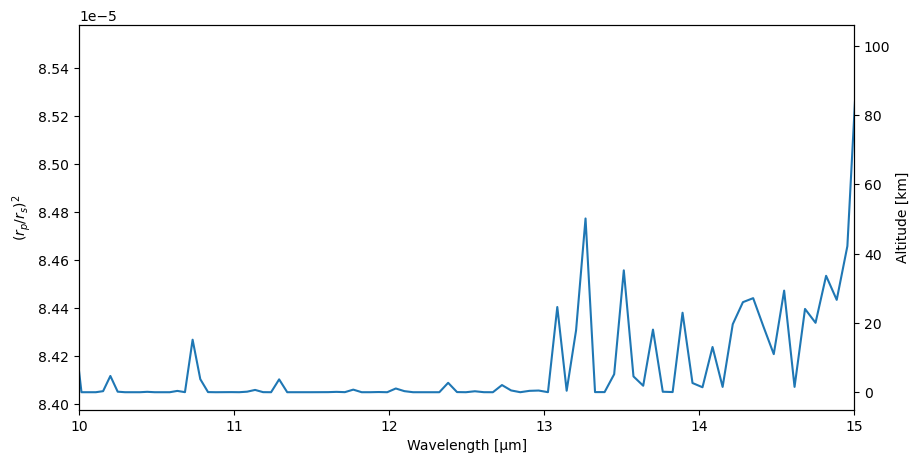

In [7]:
ax.set_xlim(10,15)
fig

Now we can show contibutions:

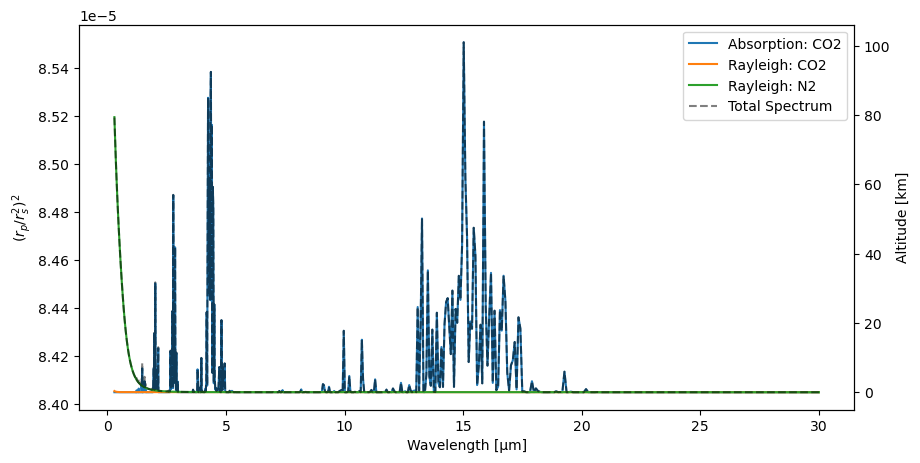

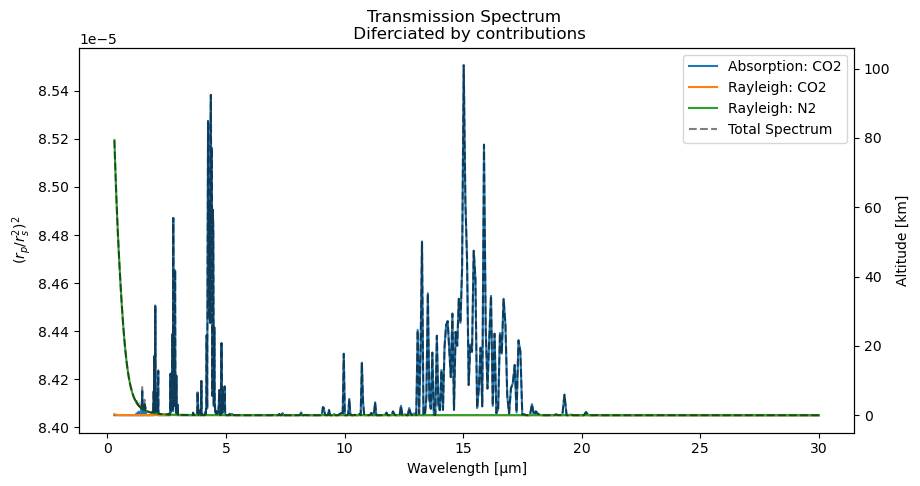

In [8]:
fig, ax = system.plot_contributions(wn_grid=wn, showfig=True, showspectrum=True) ## Add option showfig = False, plot_contributions(..., showspectrum=True)
ax.set_title("Transmission Spectrum \n Diferciated by contributions")
fig

In [9]:
data= system.explore_multiverse(
    wn_grid=wn,
    snr=10,
    n_universes=10, # n_universes : Number of universes. One planet per universe with properties drawn from the priors 
    labels="O3",
    n_observations=1000, # Number of observations per universe
    header=True, # Add header to the observations
    )

Exploring universes: 100%|██████████| 10/10 [00:01<00:00,  9.54it/s]


Generating observations for 10 spectra...


In [10]:
data.keys()

dict_keys(['spectra', 'observations'])

In [11]:
data["spectra"].describe()

,sma,seed,p_radius,p_mass,p_seed,atm temperature,atm base_pressure,atm top_pressure,atm seed,atm CO2,...,0.31270820219292045,0.31127000362355567,0.3098384195756855,0.30841341962799274,0.30699497349907345,0.3055830510467927,0.3041776222676445,0.30277865729611425,0.3013861264040437,0.29999999999999993
count,10.0,1.000000e+00,10.0,10.0,1.000000e+00,10.0,10.0,10.0,1.000000e+00,10.0,...,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,1.000000e+01,1.000000e+01,10.000000,1.000000e+01
mean,1.0,1.712255e+09,1.0,1.0,1.712255e+09,288.0,100000.0,1.0,1.712255e+09,-4.0,...,8.515397e-05,0.000085,8.516315e-05,8.516773e-05,8.517231e-05,0.000085,8.518152e-05,8.518614e-05,0.000085,8.519481e-05
std,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,1.428562e-20,0.000000,1.428562e-20,1.428562e-20,1.428562e-20,0.000000,1.428562e-20,1.428562e-20,0.000000,1.428562e-20
min,1.0,1.712255e+09,1.0,1.0,1.712255e+09,288.0,100000.0,1.0,1.712255e+09,-4.0,...,8.515397e-05,0.000085,8.516315e-05,8.516773e-05,8.517231e-05,0.000085,8.518152e-05,8.518614e-05,0.000085,8.519481e-05
25%,1.0,1.712255e+09,1.0,1.0,1.712255e+09,288.0,100000.0,1.0,1.712255e+09,-4.0,...,8.515397e-05,0.000085,8.516315e-05,8.516773e-05,8.517231e-05,0.000085,8.518152e-05,8.518614e-05,0.000085,8.519481e-05
50%,1.0,1.712255e+09,1.0,1.0,1.712255e+09,288.0,100000.0,1.0,1.712255e+09,-4.0,...,8.515397e-05,0.000085,8.516315e-05,8.516773e-05,8.517231e-05,0.000085,8.518152e-05,8.518614e-05,0.000085,8.519481e-05
75%,1.0,1.712255e+09,1.0,1.0,1.712255e+09,288.0,100000.0,1.0,1.712255e+09,-4.0,...,8.515397e-05,0.000085,8.516315e-05,8.516773e-05,8.517231e-05,0.000085,8.518152e-05,8.518614e-05,0.000085,8.519481e-05
max,1.0,1.712255e+09,1.0,1.0,1.712255e+09,288.0,100000.0,1.0,1.712255e+09,-4.0,...,8.515397e-05,0.000085,8.516315e-05,8.516773e-05,8.517231e-05,0.000085,8.518152e-05,8.518614e-05,0.000085,8.519481e-05


In [12]:
data["observations"].describe()

,noise,SNR,29.999999999999996,29.862024862864565,29.72468429701139,29.58797538393846,29.451895218566502,29.31644090917717,29.181609577351622,29.04739835790937,...,0.31270820219292045,0.31127000362355567,0.3098384195756855,0.30841341962799274,0.30699497349907345,0.3055830510467927,0.3041776222676445,0.30277865729611425,0.3013861264040437,0.29999999999999993
count,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.456121e-07,10.0,8.404952e-05,8.404959e-05,8.404901e-05,8.405010e-05,8.405051e-05,8.404893e-05,8.405084e-05,8.405220e-05,...,8.515589e-05,8.515914e-05,8.516117e-05,8.516758e-05,8.517436e-05,8.517568e-05,8.518134e-05,8.518569e-05,8.519061e-05,8.519409e-05
std,1.606796e-20,0.0,1.458732e-07,1.460932e-07,1.453499e-07,1.436151e-07,1.455045e-07,1.453964e-07,1.456806e-07,1.456425e-07,...,1.460095e-07,1.456401e-07,1.483226e-07,1.446864e-07,1.450010e-07,1.458592e-07,1.474044e-07,1.456177e-07,1.457616e-07,1.462667e-07
min,1.456121e-07,10.0,8.351781e-05,8.347346e-05,8.344924e-05,8.347498e-05,8.343543e-05,8.350626e-05,8.348466e-05,8.352419e-05,...,8.462501e-05,8.463394e-05,8.451432e-05,8.457196e-05,8.464687e-05,8.462141e-05,8.458011e-05,8.455619e-05,8.462687e-05,8.466449e-05
25%,1.456121e-07,10.0,8.395153e-05,8.395088e-05,8.395094e-05,8.395410e-05,8.394982e-05,8.395268e-05,8.395231e-05,8.395359e-05,...,8.505652e-05,8.506133e-05,8.506140e-05,8.506985e-05,8.507669e-05,8.507876e-05,8.507980e-05,8.508749e-05,8.509313e-05,8.509634e-05
50%,1.456121e-07,10.0,8.405144e-05,8.405051e-05,8.405138e-05,8.404963e-05,8.404933e-05,8.404951e-05,8.405023e-05,8.405197e-05,...,8.515670e-05,8.515903e-05,8.516303e-05,8.516812e-05,8.517408e-05,8.517579e-05,8.518333e-05,8.518614e-05,8.518972e-05,8.519454e-05
75%,1.456121e-07,10.0,8.414802e-05,8.414625e-05,8.414747e-05,8.414644e-05,8.414831e-05,8.414834e-05,8.414917e-05,8.415155e-05,...,8.525634e-05,8.525718e-05,8.526124e-05,8.526531e-05,8.527240e-05,8.527294e-05,8.527876e-05,8.528306e-05,8.528878e-05,8.529186e-05
max,1.456121e-07,10.0,8.456433e-05,8.465932e-05,8.458455e-05,8.459743e-05,8.460838e-05,8.460778e-05,8.456229e-05,8.462318e-05,...,8.578075e-05,8.570065e-05,8.571822e-05,8.571227e-05,8.571694e-05,8.579961e-05,8.573756e-05,8.577763e-05,8.585064e-05,8.581385e-05


## Creating a Multiverse

First we can create the components of a planetary system.

In [13]:
stars = mrex.Star(temperature=5777,radius=1,mass=1)
planets = mrex.Planet(radius=1,mass=1)
atmos=mrex.Atmosphere(
    temperature=288, # in K
    base_pressure=1e5, # in Pa
    top_pressure=1, # in Pa
    fill_gas="N2", # the gas that fills the atmosphere
    composition=dict(
        CO2=(-4,-1), # This is the range of log10(mix-ratio) of CO2
        H2O=(-4,-2),
        CH4=(-6,-3),
        O3=-6
    )
)
planets.set_atmosphere(atmos)
systems=mrex.System(star=stars,planet=planets,sma=1)
systems.make_tm()


Now we can initialize our model and use the other features of multirex.

Now we can generate a dataset spectra varying the parameters who we define as a range, and addionally we can add noise based on the signal to noise ratio to generate a set of observations.

Optionally we can add a label based on the presence of a molecule in the atmosphere.


In [14]:
wn=mrex.wavenumber_grid(wl_min=0.3,wl_max=30,resolution=1000)
data = systems.explore_multiverse(
    wn_grid=wn,
    snr=10,
    n_universes=10, # n_universes : Number of universes. One planet per universe with properties drawn from the priors 
    labels="O3",
    n_observations=1000, # Number of observations per universe
    header=True, # Add header to the observations
    
)
# This will produce 10 000 observations in total
"""
spectra=True,
observations=True, # Give me the observations
"""

Exploring universes: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Generating observations for 10 spectra...


'\nspectra=True,\nobservations=True, # Give me the observations\n'

Now we can visualize the dataset.

In [15]:
data["spectra"]

,sma,seed,p_radius,p_mass,p_seed,atm temperature,atm base_pressure,atm top_pressure,atm fill_gas,atm seed,...,0.31270820219292045,0.31127000362355567,0.3098384195756855,0.30841341962799274,0.30699497349907345,0.3055830510467927,0.3041776222676445,0.30277865729611425,0.3013861264040437,0.29999999999999993
0,1,1.712255e+09,1,1,1.712255e+09,288,100000.0,1,N2,1.712255e+09,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
1,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
2,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
3,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
4,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
5,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
6,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
7,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
8,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085
9,1,NaN,1,1,NaN,288,100000.0,1,N2,NaN,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085


As you can see the planets are the same since you don't include variations in the properties of the planets.

In [16]:
data["observations"].describe()

,noise,SNR,29.999999999999996,29.862024862864565,29.72468429701139,29.58797538393846,29.451895218566502,29.31644090917717,29.181609577351622,29.04739835790937,...,0.31270820219292045,0.31127000362355567,0.3098384195756855,0.30841341962799274,0.30699497349907345,0.3055830510467927,0.3041776222676445,0.30277865729611425,0.3013861264040437,0.29999999999999993
count,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,2.036652e-07,10.0,8.404618e-05,8.414849e-05,8.405671e-05,8.405678e-05,8.405166e-05,8.411179e-05,8.408400e-05,8.405505e-05,...,8.515106e-05,8.515732e-05,8.516276e-05,8.516421e-05,8.517272e-05,8.517431e-05,8.518382e-05,8.518601e-05,8.519133e-05,8.519080e-05
std,2.684368e-08,0.0,2.033639e-07,2.129636e-07,2.075911e-07,2.075867e-07,2.065250e-07,2.076999e-07,2.070624e-07,2.043482e-07,...,2.061526e-07,2.068136e-07,2.068786e-07,2.052894e-07,2.042515e-07,2.065860e-07,2.060213e-07,2.048351e-07,2.056822e-07,2.060404e-07
min,1.519626e-07,10.0,8.329139e-05,8.332030e-05,8.321696e-05,8.323156e-05,8.327577e-05,8.332330e-05,8.330506e-05,8.323808e-05,...,8.433005e-05,8.436115e-05,8.434767e-05,8.441118e-05,8.429834e-05,8.438531e-05,8.440419e-05,8.423190e-05,8.436708e-05,8.428243e-05
25%,1.914401e-07,10.0,8.391286e-05,8.400843e-05,8.392107e-05,8.392027e-05,8.391446e-05,8.397353e-05,8.394779e-05,8.392286e-05,...,8.501424e-05,8.502188e-05,8.502931e-05,8.503030e-05,8.503799e-05,8.504114e-05,8.505035e-05,8.504982e-05,8.505500e-05,8.505392e-05
50%,2.086153e-07,10.0,8.404839e-05,8.415431e-05,8.405744e-05,8.405700e-05,8.405063e-05,8.411336e-05,8.408610e-05,8.405178e-05,...,8.515120e-05,8.515647e-05,8.516361e-05,8.516662e-05,8.517366e-05,8.517443e-05,8.518740e-05,8.518506e-05,8.519289e-05,8.519402e-05
75%,2.248212e-07,10.0,8.418113e-05,8.429171e-05,8.418936e-05,8.419238e-05,8.418855e-05,8.425180e-05,8.422114e-05,8.418982e-05,...,8.528531e-05,8.529330e-05,8.529762e-05,8.529765e-05,8.530678e-05,8.530825e-05,8.531964e-05,8.532119e-05,8.532895e-05,8.532666e-05
max,2.356291e-07,10.0,8.473686e-05,8.503285e-05,8.480189e-05,8.494727e-05,8.488573e-05,8.501985e-05,8.498243e-05,8.483357e-05,...,8.598623e-05,8.600380e-05,8.594546e-05,8.610538e-05,8.602595e-05,8.606050e-05,8.603108e-05,8.603935e-05,8.598754e-05,8.595772e-05


In [17]:
spectra,obs=data.values()

You generate a dataset with variations in the properties concentration of $CO_2$, you can see the variations in the dataset and view we haver 1000 observations for each concentration.

In [18]:
obs["atm CO2"].value_counts()

atm CO2
-1.0536172982205008    1000
-3.9220648738322903    1000
-1.9271279410846107    1000
-3.5617477184835855    1000
-2.9205556932458268    1000
-2.362793755302884     1000
-1.8792555820020436    1000
-3.4924122032709413    1000
-3.699762777736606     1000
-3.2031023562309384    1000
Name: count, dtype: int64

The dataframes has attribues data and params, that contains the columns with this information:
- params: The parameters how has generated the observation and spectrum.
- data: The value of spectra.

<>:10: DeprecationWarning: invalid escape sequence '\m'
<>:10: DeprecationWarning: invalid escape sequence '\m'
C:\Users\santi\AppData\Local\Temp\ipykernel_26260\3677066989.py:10: DeprecationWarning: invalid escape sequence '\m'
  plt.xlabel("Wavelength [$\mu$m]")


Text(0.5, 1.0, 'Example of a Spectrum and its observation')

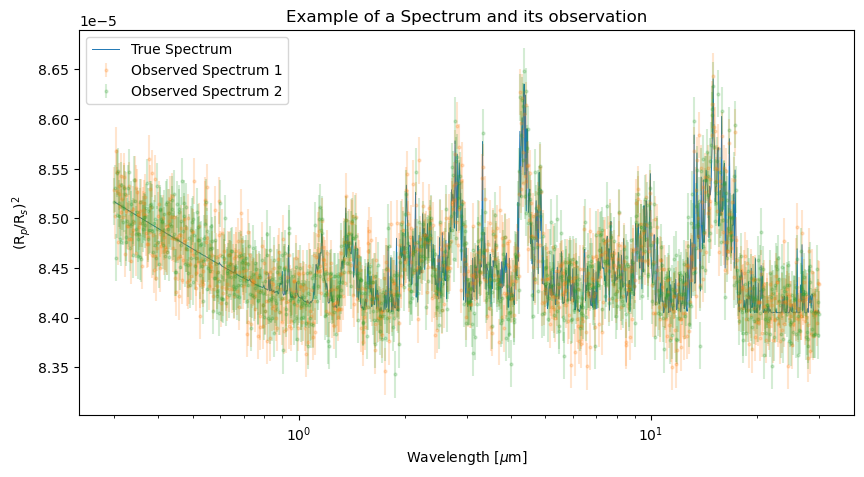

In [19]:
##
plt.figure(figsize=(10,5))
plt.plot(spectra.data.iloc[0],label="True Spectrum",linewidth=0.7)
plt.errorbar(x=1e4/wn,y=obs.data.iloc[0],yerr=obs.params["noise"][0]*np.ones(1000),
            label="Observed Spectrum 1",fmt="o",markersize=2,alpha=0.2)
plt.errorbar(x=1e4/wn,y=obs.data.iloc[1],yerr=obs.params["noise"][1]*np.ones(1000),
            label="Observed Spectrum 2",fmt="o",markersize=2,alpha=0.2)
plt.xscale("log")
plt.legend()
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("(R$_p$/R$_s$)$^2$")
plt.title("Example of a Spectrum and its observation")
